# IAQ and Fitbit-Measured Sleep Exploration
Arguably the main attraction (for me at least), we explore the effect of IAQ parameters on Fitbit-measured sleep parameters.

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Percent Change in Nightly Pollutants and Fitbit-Measured SE/REM:NREM

At the writing of this notebook, the beacons have not been post-calibrated. Therefore the pollutant metric to consider is the percent change or some differencing approach because the changes are correct, while the values might not be.

In [2]:
import os
import sys
sys.path.append('../')

from src.features import build_features
from src.visualization import visualize
from src.reports import make_report

import pandas as pd
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

import statsmodels.api as sm

## Data Import
For this analysis we need both daily Fitbit sleep summary and the sleep stages summary files

### Fitbit Sleep Summary

In [3]:
sleep = pd.read_csv("../data/processed/bpeace2-fitbit-sleep-daily.csv",
                    parse_dates=['date','startTime','endTime'],infer_datetime_format=True)
end_dates = []
for d in sleep['endTime']:
    end_dates.append(d.date())
sleep['endDate'] = end_dates
sleep.head()

,date,dateOfSleep,duration,efficiency,endTime,infoCode,isMainSleep,logId,minutesAfterWakeup,minutesAsleep,minutesAwake,minutesToFallAsleep,startTime,timeInBed,beiwe,endDate
0,2020-05-14,2020-05-14,24360000,97,2020-05-14 07:13:00,0,True,27170628887,0,379,27,0,2020-05-14 00:27:00,406,hfttkth7,2020-05-14
1,2020-05-15,2020-05-15,29580000,87,2020-05-15 08:06:30,0,True,27187368950,8,392,101,0,2020-05-14 23:53:30,493,hfttkth7,2020-05-15
2,2020-05-16,2020-05-16,19740000,95,2020-05-16 04:57:00,0,True,27197675883,7,287,42,0,2020-05-15 23:28:00,329,hfttkth7,2020-05-16
3,2020-05-17,2020-05-17,26820000,96,2020-05-17 09:28:30,0,True,27214680283,8,403,44,0,2020-05-17 02:01:30,447,hfttkth7,2020-05-17
4,2020-05-18,2020-05-18,24960000,92,2020-05-18 07:20:00,0,True,27227113904,0,351,65,0,2020-05-18 00:24:00,416,hfttkth7,2020-05-18


### Fitbit Sleep Stage Summary

In [4]:
stages = pd.read_csv("../data/processed/bpeace2-fitbit-sleep-stages-summary.csv",
                     index_col=0,parse_dates=['startDate','endDate'],infer_datetime_format=True)
end_dates = []
for d in stages['endDate']:
    end_dates.append(d.date())
stages['endDate'] = end_dates
stages.head()

,startDate,endDate,deep_count,deep_minutes,light_count,light_minutes,rem_count,rem_minutes,wake_count,wake_minutes,beiwe
0,2020-05-14,2020-05-14,5,84,20,213,10,82,21,27,hfttkth7
1,2020-05-14,2020-05-15,4,95,31,250,6,47,33,101,hfttkth7
2,2020-05-15,2020-05-16,2,47,17,190,8,50,20,42,hfttkth7
3,2020-05-17,2020-05-17,5,78,21,242,11,83,25,44,hfttkth7
4,2020-05-18,2020-05-18,5,96,20,167,14,88,28,65,hfttkth7


### Beacon IAQ
And lastly the IAQ measurements courtesy of the beacons

In [5]:
beacon = pd.read_csv('../data/processed/bpeace2-beacon.csv',index_col=0,parse_dates=True)
beacon.head()

,TVOC,eCO2,Lux,Visible,Infrared,NO2,T_NO2,RH_NO2,CO,T_CO,...,PM_N_10,PM_C_1,PM_C_2p5,PM_C_4,PM_C_10,z,Beacon,Beiwe,Fitbit,REDCap
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-06-11 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,30,idbkjh8u,22,4
2020-06-11 00:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,30,idbkjh8u,22,4
2020-06-11 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,30,idbkjh8u,22,4
2020-06-11 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,30,idbkjh8u,22,4
2020-06-11 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,30,idbkjh8u,22,4


## Pre-processing
The new Fitbit files nicely summarize the sleep data for us and also give the start and stop times for the sleep events (SO convenient!). The only thing we have to pre-process is the beacon data by removing all data for each participant that is not in their daily sleep windows. 

However, since the stages summary and sleep summary come from different files, I need to make sure that they have the same number of nights per participant.

In [6]:
for pt in sleep['beiwe'].unique():
    sleep_pt = sleep[sleep['beiwe'] == pt]
    stage_pt = stages[stages['beiwe'] == pt]
    if len(sleep_pt) != len(stage_pt):
        print('{pt}: different lengths')

Nothing was printed so they seem to be the same length!

### IAQ and Sleep Summary per Night
Now we can loop through the start and stop times for sleep, get the IAQ data, summarize it, and then combine the three dataframes into one.

In addition, we will save a dataframe that has the unaltered measurements during the evening in case we want to take a look at the trends, measurements, distributions, etc.

In [7]:
iaq_sleep = pd.DataFrame() # summary dataframe holding the nightly sleep measurements and summarized IAQ data
nightly_iaq = pd.DataFrame() # dataframe holding the measured IAQ values for each pt
for pt in sleep['beiwe'].unique():
    # getting data per participant
    beacon_pt = beacon[beacon['Beiwe'] == pt]
    sleep_pt = sleep[sleep['beiwe'] == pt]
    stages_pt = stages[stages['beiwe'] == pt]
    # summarizing beacon data per night
    beacon_summary = pd.DataFrame()
    for start_time, end_time in zip(sleep_pt['startTime'],sleep_pt['endTime']):
        beacon_pt_night = beacon_pt[start_time:end_time]
        if len(beacon_pt_night) > 0:
            nightly_temp = beacon_pt_night
            nightly_temp['start_time'] = start_time
            nightly_temp['end_time'] = end_time
            nightly_temp['beiwe'] = pt
            nightly_iaq = nightly_iaq.append(nightly_temp)
            summary_dict = {'start_date':[start_time.date()],'end_date':[end_time.date()]}
            for variable in ['CO2','PM_C_2p5','CO','NO2','TVOC']:
                summary_dict[f'{variable}_min'] = np.nanmin(beacon_pt_night[variable])
                summary_dict[f'{variable}_max'] = np.nanmax(beacon_pt_night[variable])
                summary_dict[f'{variable}_mean'] = np.nanmean(beacon_pt_night[variable])
                summary_dict[f'{variable}_med'] = np.nanmedian(beacon_pt_night[variable])
                summary_dict[f'{variable}_25'] = np.percentile(beacon_pt_night[variable],25)
                summary_dict[f'{variable}_75'] = np.percentile(beacon_pt_night[variable],75)
                summary_dict[f'{variable}_std'] = np.nanstd(beacon_pt_night[variable])
                summary_dict[f'{variable}_initial'] = beacon_pt_night[variable][0]
                summary_dict[f'{variable}_final'] = beacon_pt_night[variable][-1]
                
            beacon_summary = beacon_summary.append(pd.DataFrame(summary_dict))
    if len(beacon_summary) > 0:
        temp = pd.merge(left=beacon_summary,right=sleep_pt,left_on='end_date',right_on='endDate',how='inner')
        iaq_sleep_pt = pd.merge(left=temp,right=stages_pt,left_on='end_date',right_on='endDate',how='inner')
        iaq_sleep = iaq_sleep.append(iaq_sleep_pt)
        
# adding in REM:nREM
iaq_sleep['rem2nrem'] = iaq_sleep['rem_minutes'] / (iaq_sleep['light_minutes'] + iaq_sleep['deep_minutes'])

Now we save both dataframes to the processed folder.

In [8]:
iaq_sleep.to_csv('../data/processed/bpeace2-fitbit-beacon-iaq-evening-summary.csv')
nightly_iaq.to_csv('../data/processed/bpeace2-fitbit-beacon-iaq-evening-full.csv')

## Analyzing

In [9]:
from scipy import stats

We can start to analyze by looking at the differences in the means of different sleep parameters under low and high concentration nights. We can define a low and high concentration night however we see fit.

### Lower 50th and Upper 50th percentiles

In [10]:
for pollutant in ['CO2','PM_C_2p5','NO2','CO','TVOC']:
    high = pd.DataFrame()
    low = pd.DataFrame()
    for pt in iaq_sleep['beiwe_x'].unique():
        iaq_sleep_pt = iaq_sleep[iaq_sleep['beiwe_x'] == pt]
        iaq_sleep_pt['percentile'] = iaq_sleep_pt[f'{pollutant}_med'].rank(pct=True)
        low = low.append(iaq_sleep_pt[iaq_sleep_pt['percentile'] < 0.5])
        high = high.append(iaq_sleep_pt[iaq_sleep_pt['percentile'] >= 0.5])
    
    print(f'Pollutant: {pollutant}:')
    stat, pval = stats.ttest_ind(low['efficiency'],high['efficiency'],equal_var=False)
    print(f'\tEfficiency P: {pval}')
    stat, pval = stats.ttest_ind(low['rem2nrem'],high['rem2nrem'],equal_var=False)
    print(f'\tREM:nREM P: {pval}')

Pollutant: CO2:
	Efficiency P: 0.8973645223800049
	REM:nREM P: 0.6552877145163892
Pollutant: PM_C_2p5:
	Efficiency P: 0.6353365990572633
	REM:nREM P: 0.7232021352590277
Pollutant: NO2:
	Efficiency P: 0.40352931426044647
	REM:nREM P: 0.6458572261329246
Pollutant: CO:
	Efficiency P: 0.880831050553105
	REM:nREM P: 0.20676648516856747
Pollutant: TVOC:
	Efficiency P: 0.9019744408744841
	REM:nREM P: 0.9860573555066388


### Nights above high concentrations

In [11]:
overall = pd.DataFrame()
iaq_sleep_analysis = iaq_sleep[iaq_sleep['efficiency'] > 65]
for pollutant, threshold in zip(['CO2','PM_C_2p5','NO2','CO','TVOC'],[1000,12,200,5,250]):
    high = pd.DataFrame()
    low = pd.DataFrame()
    for pt in iaq_sleep['beiwe_x'].unique():
        iaq_sleep_pt = iaq_sleep_analysis[iaq_sleep_analysis['beiwe_x'] == pt]
        low = low.append(iaq_sleep_pt[iaq_sleep_pt[f'{pollutant}_med'] < threshold])
        high = high.append(iaq_sleep_pt[iaq_sleep_pt[f'{pollutant}_med'] >= threshold])
    
    print(f'Pollutant: {pollutant}:')
    stat, pval = stats.ttest_ind(low['efficiency'],high['efficiency'],equal_var=False)
    print(f'\tEfficiency P: {pval}')
    stat, pval = stats.ttest_ind(low['rem2nrem'],high['rem2nrem'],equal_var=False)
    print(f'\tREM:nREM P: {pval}')
    
    low['cat'] = 'Low'
    high['cat'] = 'High'
    comb = low.append(high)
    comb['Pollutant'] = pollutant
    overall = overall.append(comb)

Pollutant: CO2:
	Efficiency P: 0.0003324933346446932
	REM:nREM P: 0.8315509382716626
Pollutant: PM_C_2p5:
	Efficiency P: 0.9180832600704968
	REM:nREM P: 0.014824270386284331
Pollutant: NO2:
	Efficiency P: 8.16294047467952e-09
	REM:nREM P: 0.05763361072328754
Pollutant: CO:
	Efficiency P: 0.0002540309911583198
	REM:nREM P: 0.2424019456324223
Pollutant: TVOC:
	Efficiency P: 0.10618331000664241
	REM:nREM P: 0.0029866191958005392


In [12]:
plt.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
plt.rcParams['font.family'] = "sans-serif"

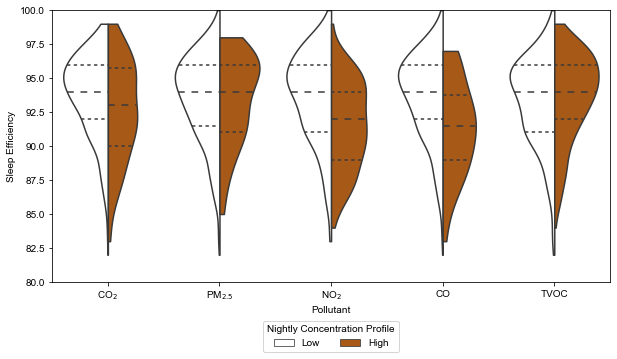

In [13]:
fig, ax = plt.subplots(figsize=(10,5))
sns.violinplot(x='Pollutant',y='efficiency',hue='cat',data=overall,cut=0,split=True,inner='quartile',palette=['white','#BF5700'],ax=ax)
ax.set_ylim([80,100])
ax.set_yticks(np.arange(80,102,2.5))
ax.legend(title='Nightly Concentration Profile',loc='center',bbox_to_anchor=(0.5,-.2),ncol=2)
ax.set_ylabel('Sleep Efficiency')
ax.set_xticklabels(['CO$_2$','PM$_{2.5}$','NO$_2$','CO','TVOC'])

plt.savefig('../reports/IA2020_poster/beacon-fitbit-median_pollutant-efficiency.pdf')
plt.show()
plt.close()

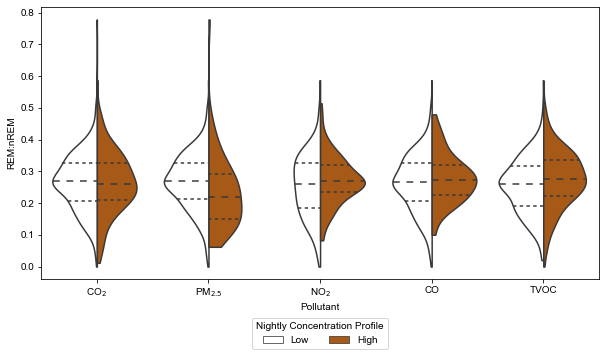

In [14]:
fig, ax = plt.subplots(figsize=(10,5))
sns.violinplot(x='Pollutant',y='rem2nrem',hue='cat',data=overall,cut=0,split=True,inner='quartile',palette=['white','#BF5700'],ax=ax)
ax.legend(title='Nightly Concentration Profile',loc='center',bbox_to_anchor=(0.5,-.2),ncol=2)
ax.set_ylabel('REM:nREM')
ax.set_xticklabels(['CO$_2$','PM$_{2.5}$','NO$_2$','CO','TVOC'])

plt.savefig('../reports/IA2020_poster/beacon-fitbit-median_pollutant-rem2nrem.pdf')
plt.show()
plt.close()

## Visualizing
With these data summamrized, we can start to look at the relationship between sleep and IAQ.

We can start simple by looking at one variable and it's effect on sleep efficiency. Then the code we develop here can be adapted for analysis on other variables. 

In [15]:
overall['Pollutant'].unique()

array(['CO2', 'PM_C_2p5', 'NO2', 'CO', 'TVOC'], dtype=object)

In [16]:
for pollutant in overall['Pollutant'].unique():
    df = overall[overall['Pollutant'] == pollutant]
    n_low = len(df[df['cat'] == 'Low'])
    n_high = len(df[df['cat'] == 'High'])
    print(f'{pollutant}:\n\tn (high): {n_high}\n\tn (low): {n_low}\n\ttotal: {n_low+n_high}')

CO2:
	n (high): 154
	n (low): 544
	total: 698
PM_C_2p5:
	n (high): 67
	n (low): 643
	total: 710
NO2:
	n (high): 117
	n (low): 331
	total: 448
CO:
	n (high): 42
	n (low): 641
	total: 683
TVOC:
	n (high): 342
	n (low): 340
	total: 682


### CO2 and Sleep Efficiency
We can look at a scatterplot comparing multiple summary statistics of CO2 with sleep efficiency.

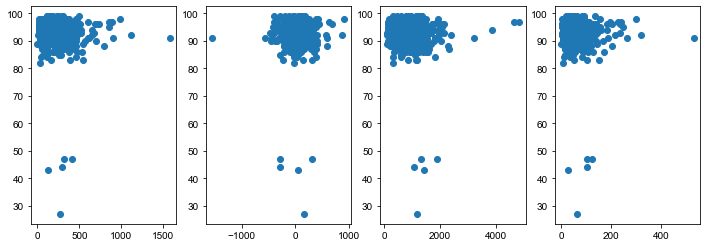

In [17]:
fig, ax = plt.subplots(1,4,figsize=(12,4))
co2 = iaq_sleep
co2['diff'] = co2['CO2_max'] - co2['CO2_min']
co2['delta'] = co2['CO2_final'] - co2['CO2_initial']
i = 0
for stat in ['diff','delta','CO2_med','CO2_std']:
    ax[i].scatter(co2[stat],co2['efficiency'])
    i += 1

# Old

### Percent Change Histogram
The first thing to do is create a histogram of the percentage change values for each pollutant.

In [18]:
iaq_sleep.columns

Index(['start_date', 'end_date', 'CO2_min', 'CO2_max', 'CO2_mean', 'CO2_med',
       'CO2_25', 'CO2_75', 'CO2_std', 'CO2_initial', 'CO2_final',
       'PM_C_2p5_min', 'PM_C_2p5_max', 'PM_C_2p5_mean', 'PM_C_2p5_med',
       'PM_C_2p5_25', 'PM_C_2p5_75', 'PM_C_2p5_std', 'PM_C_2p5_initial',
       'PM_C_2p5_final', 'CO_min', 'CO_max', 'CO_mean', 'CO_med', 'CO_25',
       'CO_75', 'CO_std', 'CO_initial', 'CO_final', 'NO2_min', 'NO2_max',
       'NO2_mean', 'NO2_med', 'NO2_25', 'NO2_75', 'NO2_std', 'NO2_initial',
       'NO2_final', 'TVOC_min', 'TVOC_max', 'TVOC_mean', 'TVOC_med', 'TVOC_25',
       'TVOC_75', 'TVOC_std', 'TVOC_initial', 'TVOC_final', 'date',
       'dateOfSleep', 'duration', 'efficiency', 'endTime', 'infoCode',
       'isMainSleep', 'logId', 'minutesAfterWakeup', 'minutesAsleep',
       'minutesAwake', 'minutesToFallAsleep', 'startTime', 'timeInBed',
       'beiwe_x', 'endDate_x', 'startDate', 'endDate_y', 'deep_count',
       'deep_minutes', 'light_count', 'light_minutes',

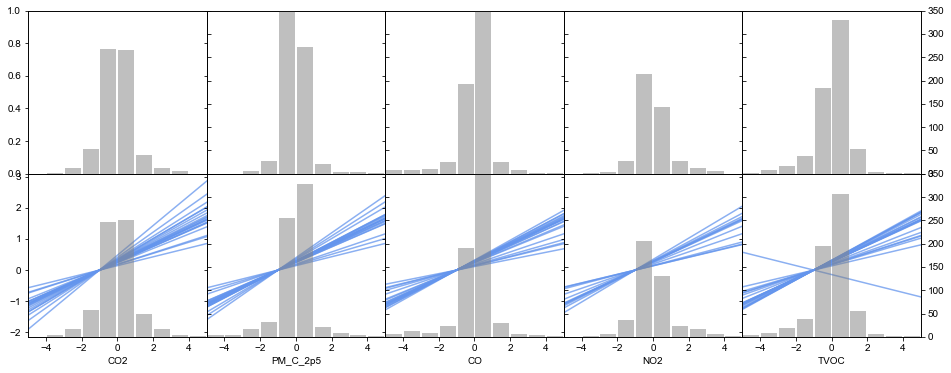

In [19]:
fig, axes = plt.subplots(2,5,figsize=(16,6),sharex='col',sharey='row')
r = 0
for sleep_metric in ['efficiency','rem2nrem']:
    c = 0
    for variable in ['CO2','PM_C_2p5','CO','NO2','TVOC']:
        ax = axes[r,c]
        temp = iaq_sleep
        diff = (iaq_sleep[f'{variable}_final']-iaq_sleep[f'{variable}_initial']) 
        temp['z'] = (diff - np.nanmean(diff)) / np.nanstd(diff)
        temp[abs(temp['z']) > 5] = np.nan
        for pt in temp['beiwe_x'].unique():
            temp_pt = temp[temp['beiwe_x'] == pt]
            temp_pt = temp_pt.dropna(subset=['z',sleep_metric])
            x = temp_pt['z'].values
            y = temp_pt[sleep_metric].values
            if len(x) > 1:
                # OLS - intercept at origin
                pt_model = sm.OLS(y,sm.add_constant(x)).fit()

                if pt_model.params[0]*-5 < -4:
                    pass
                else:
                    ax.plot([-5,5],[pt_model.params[0]+pt_model.params[0]*-5,pt_model.params[0]+pt_model.params[0]*5],color='cornflowerblue',alpha=0.75)
        
        ax2 = ax.twinx()
        ax2.hist(temp['z'],color='gray',bins=np.arange(-5,6,1),rwidth=0.9,alpha=0.5,zorder=1)
        ax2.set_xlim([-5,5])
        ax2.set_ylim([0,350])
        if r == 1:
            ax.set_xlabel(f'{variable}')
        if c == 4:
            pass
        else:
            ax2.set_yticklabels([''])
        c += 1
        
    r += 1
    
plt.subplots_adjust(hspace=0,wspace=0)
plt.show()
plt.close()